In [1]:
cd ..

m:\OneDrive\Projects\federated_imputation


# Functions and utils

In [230]:
%load_ext autoreload
%autoreload
from src.fed_imp.experiment import Experiment

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
import numpy as np
from scipy.special import kl_div
from scipy.stats import wasserstein_distance
from scipy.stats import pearsonr

def kl_divergence(p, q):
    return kl_div(p, q).sum()

def pearson_correlation(p, q):
    correlation, _ = pearsonr(p, q)
    return correlation

def euclidean_distance(p, q):
    return np.linalg.norm(p - q)

def cosine_similarity(p, q):
    return np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))

import numpy as np
import ot

In [71]:
experiment_config_template = {
  "num_clients": 20,
  "data": {
    "dataset_name": "ijcnn_balanced",
    "normalize": True
  },
  "data_partition": {
    "strategy": "sample@p=0.01",
    "params": {}
  },
  "missing_simulate": {
    "mr_strategy": "fixed",
    "mf_strategy": "all",
    "mm_strategy": "mary_lr"
  },
  "imputation": {
    "initial_strategy_num": "mean",
    "initial_strategy_cat": "mode",
    "estimator_num": "ridge_cv",
    "estimator_cat": "logistic_cv",
    "imp_evaluation_model": "logistic",
    "imp_evaluation_params": {
      "tune_params": "gridsearch"
    },
    "clip": False
  },
  "agg_strategy_imp": {
    "strategy": "fedavg-s",
    "params": {
      "ms_field": "missing_cell_pct",
      "beta": 0.7
    }
  },
  "server_type": "fedavg_pytorch",
  "server": {
    "impute_mode": "instant",
    "imp_round": 40,
    "imp_local_epochs": 0,
    "pred_round": 0,
    "pred_local_epochs": 0,
    "model_fit_mode": "one_shot"
  },
  "pred_model": {
    "model_params": {
      "model": "2nn",
      "num_hiddens": 128,
      "model_init_config": None,
      "model_other_params": None
    },
    "train_params": {
      "batch_size": 128,
      "learning_rate": 0.001,
      "weight_decay": 0.0001,
      "pred_round": 200,
      "pred_local_epochs": 3
    }
  },
  "experiment": {
    "n_rounds": 1,
    "seed": 102931466,
    "mtp": False,
    "random_seed": 50,
    "num_process": 3,
    "track": True
  },
  "tune_params": False,
  "algo_params": {
    "local": {},
    "fedavg-s": {},
    "fedwavg": {
      "alpha": 0.9
    },
    "fedmechw": {
      "client_thres": 1.0,
      "alpha": 0.8,
      "beta": 0.15
    },
    "fedmechclw": {
      "client_thres": 0.2,
      "thres1": 0.2,
      "alpha": 0.5
    },
    "scale_factor": 4
  }
}

# CASE1

## Federated Imputation - naive average

In [231]:
exp_config1 = experiment_config_template.copy()
exp_config1['dataset_name'] = 'ijcnn_balanced'
exp_config1['num_clients'] = 20
exp_config1['data_partition']['strategy'] = 'sample@p=0.01'
exp_config1["missing_simulate"]["mr_strategy"] = "random_in_group2"
exp_config1["missing_simulate"]["mm_strategy"] = "mary_lr"
exp_config1["agg_strategy_imp"]["strategy"] = "fedavg-s"
exp_config1["server"]["imp_round"] = 40

In [232]:
experiment = Experiment()
ret1, stats1 = experiment.run_experiment(exp_config1)

2023-07-14 17:22:09.907 | INFO     | src.fed_imp.experiment:main_func:27 - Round 0


sample {'p': '0.01'}
{}


2023-07-14 17:26:46.826 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 23
2023-07-14 17:27:14.136 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 34
2023-07-14 17:27:29.976 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 23
2023-07-14 17:27:46.100 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 23
2023-07-14 17:28:00.824 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 21
2023-07-14 17:28:12.568 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 17
2023-07-14 17:28:25.695 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 19
2023-07-14 17:28:39.595 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 20
2023-07-14 17:28:50.756 

In [63]:
client_infos1 = stats1[0][0].client_infos

for client_info in client_infos1:
    print("====================================================================================")
    print("client_id:", client_info.client_id)
    print("num of data imputed:", len(client_info.data_imp))
    print("Data shape: {} {}".format(client_info.data_true.shape[0], client_info.data_true.shape[1]))
    print("Missing ratio: {}".format(client_info.missing_mask.sum().sum()/client_info.missing_mask.size))

records1 = stats1[0][0].records
len(records1)

client_id: 0
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.4728682170542636
client_id: 1
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.49224806201550386
client_id: 2
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.4728682170542636
client_id: 3
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.40310077519379844
client_id: 4
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.3449612403100775
client_id: 5
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5
client_id: 6
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5852713178294574
client_id: 7
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5775193798449613
client_id: 8
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.6046511627906976
client_id: 9
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5930232558139535
client_id: 10
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.4728682170542636
client_id: 11
num of d

880

## Federated Imputation - weighted average

In [233]:
exp_config2 = experiment_config_template.copy()
exp_config2['dataset_name'] = 'ijcnn_balanced'
exp_config2['num_clients'] = 20
exp_config2['data_partition']['strategy'] = 'sample@p=0.01'
exp_config2["missing_simulate"]["mr_strategy"] = "random_in_group2"
exp_config2["missing_simulate"]["mm_strategy"] = "mary_lr"
exp_config2["agg_strategy_imp"]["strategy"] = "fedmechw"
exp_config2["server"]["imp_round"] = 40

In [234]:
experiment = Experiment()
ret, stats = experiment.run_experiment(exp_config2)

2023-07-14 17:30:34.816 | INFO     | src.fed_imp.experiment:main_func:27 - Round 0


sample {'p': '0.01'}
{'client_thres': 1.0, 'alpha': 0.8, 'beta': 0.15}


2023-07-14 17:34:46.918 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 61
2023-07-14 17:34:57.463 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 17:35:15.273 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 26
2023-07-14 17:35:25.727 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 17:35:40.085 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 19
2023-07-14 17:35:53.974 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 17
2023-07-14 17:36:06.180 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 17:36:17.658 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 17:36:28.972 

In [74]:
client_infos2 = stats[0][0].client_infos

for client_info in client_infos2:
    print("====================================================================================")
    print("client_id:", client_info.client_id)
    print("num of data imputed:", len(client_info.data_imp))
    print("Data shape: {} {}".format(client_info.data_true.shape[0], client_info.data_true.shape[1]))
    print("Missing ratio: {}".format(client_info.missing_mask.sum().sum()/client_info.missing_mask.size))

records2 = stats[0][0].records
len(records2)

client_id: 0
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.4728682170542636
client_id: 1
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.49224806201550386
client_id: 2
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.4728682170542636
client_id: 3
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.40310077519379844
client_id: 4
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.3449612403100775
client_id: 5
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5
client_id: 6
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5852713178294574
client_id: 7
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5775193798449613
client_id: 8
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.6046511627906976
client_id: 9
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.5930232558139535
client_id: 10
num of data imputed: 41
Data shape: 258 23
Missing ratio: 0.4728682170542636
client_id: 11
num of d

880

## Analysis

In [89]:
feature_list = list(range(22))
iter_list = list(range(1, 41))

In [201]:
def weight_dis(iteration, feature_idx, records1, records2):
    record1 = [record for record in records1 if record.iteration == iteration and record.feature_idx == feature_idx]
    record2 = [record for record in records2 if record.iteration == iteration and record.feature_idx == feature_idx]
    weights2 = record2[0].aggregation_weights
    weights1 = record1[0].aggregation_weights
    for idx, weight in enumerate(weights2):
        print(
            idx, kl_divergence(weights1, weight), kl_divergence(weight, weights1),
            wasserstein_distance(weights1, weight), euclidean_distance(weights1, weight)
        )

def global_model_dis(iteration, feature_idx, records1, records2):
    record1 = [record for record in records1 if record.iteration == iteration and record.feature_idx == feature_idx]
    record2 = [record for record in records2 if record.iteration == iteration and record.feature_idx == feature_idx]
    weights2 = record2[0].global_model_params
    weights1 = record1[0].global_model_params
    len_client = len(weights1)

    for idx in range(len_client):
        param1 = weights1[idx]
        param2 = weights2[idx]
        print( "{} {:.3f} {:.3f}".format(
            idx, euclidean_distance(param1, param2), cosine_similarity(param1, param2))
        )



In [196]:
def get_weight_kl(client_idx, feature_idx, records1, records2):

    ret, ret_norm, ret_cos = [], [], []
    for iteration in iter_list:
        record1 = [record for record in records1 if record.iteration == iteration and record.feature_idx == feature_idx]
        record2 = [record for record in records2 if record.iteration == iteration and record.feature_idx == feature_idx]
        weights2 = record2[0].aggregation_weights
        weights1 = record1[0].aggregation_weights
        weight_our = weights2[client_idx]
        ret.append(kl_divergence(weight_our, weights1))
        ret_norm.append(np.min(weight_our))
        ret_cos.append(cosine_similarity(weights1, weight_our))
    
    return ret, ret_norm, ret_cos

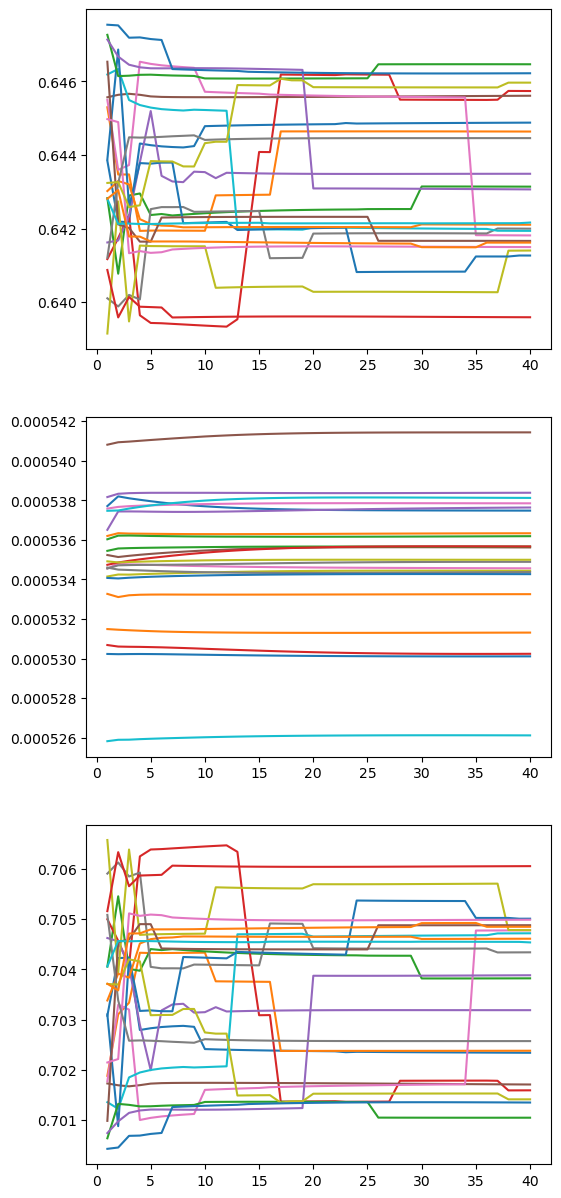

In [198]:
from matplotlib import pyplot as plt
n_cols = 5
client_idx = 0
fig, axes = plt.subplots(3, 1, figsize=(6, 15), squeeze=False)
x = iter_list
for feature_idx in feature_list:
    kl, mean, cos = get_weight_kl(client_idx, feature_idx=feature_idx, records1=records1, records2=records2)
    axes[0, 0].plot(x, kl, label="feature {}".format(feature_idx))
    axes[1, 0].plot(x, mean, label="feature {}".format(feature_idx))
    axes[2, 0].plot(x, cos, label="feature {}".format(feature_idx))

plt.show()

In [165]:
iteration = iter_list[-1]
for feature_idx in feature_list:
    print("====================================================================================")
    print("feature_idx:", feature_idx)
    weight_dis(iteration, feature_idx, records1, records2)

feature_idx: 0
0 1.5768870343764034 0.6448790752159437 0.04188818634384048 0.2227125189051837
1 1.5766942806573598 0.6433504322477409 0.04188861189627572 0.22230869769577444
2 1.5650328187483633 0.6427702268049439 0.04188828047165632 0.22227534140776287
3 1.529323165895348 0.640015018214903 0.04188701877205691 0.2215808042740797
4 1.5329968641921552 0.6384662767032508 0.0418857923762777 0.22116594876437218
5 1.5695916289957457 0.6421031304190303 0.041888516446580606 0.22206858579895092
6 1.5887966329884236 0.6471577098608181 0.04188830008318107 0.22331088359800225
7 1.5789946128942514 0.6475173450008309 0.04188722287866527 0.22341357941779028
8 1.5798895385993026 0.6448449859918053 0.041884464480782035 0.22281426611295155
9 1.5896528605937947 0.6490094702108713 0.04188811670410544 0.2237164368671526
10 1.5433441854987056 0.6385667378023437 0.04188753387496974 0.22122747832110132
11 1.548408133988886 0.6395259479719868 0.041888528792772946 0.22142638738586287
12 1.5340632818028583 0.642

In [202]:
iteration = iter_list[-1]
for feature_idx in feature_list:
    print("====================================================================================")
    print("feature_idx:", feature_idx)
    global_model_dis(iteration, feature_idx, records1, records2)

feature_idx: 0
0 0.060 1.000
1 0.060 1.000
2 0.060 1.000
3 0.060 1.000
4 0.060 1.000
5 0.060 1.000
6 0.060 1.000
7 0.060 1.000
8 0.060 1.000
9 0.060 1.000
10 0.063 1.000
11 0.062 1.000
12 0.063 1.000
13 0.063 1.000
14 0.063 1.000
15 0.062 1.000
16 0.062 1.000
17 0.062 1.000
18 0.063 1.000
19 0.062 1.000
feature_idx: 1
0 0.031 1.000
1 0.031 1.000
2 0.031 1.000
3 0.031 1.000
4 0.031 1.000
5 0.031 1.000
6 0.030 1.000
7 0.030 1.000
8 0.030 1.000
9 0.030 1.000
10 0.022 1.000
11 0.022 1.000
12 0.022 1.000
13 0.022 1.000
14 0.022 1.000
15 0.022 1.000
16 0.022 1.000
17 0.022 1.000
18 0.022 1.000
19 0.022 1.000
feature_idx: 2
0 0.053 1.000
1 0.053 1.000
2 0.054 1.000
3 0.054 1.000
4 0.053 1.000
5 0.052 1.000
6 0.053 1.000
7 0.052 1.000
8 0.052 1.000
9 0.052 1.000
10 0.040 1.000
11 0.040 1.000
12 0.040 1.000
13 0.040 1.000
14 0.040 1.000
15 0.040 1.000
16 0.040 1.000
17 0.040 1.000
18 0.040 1.000
19 0.040 1.000
feature_idx: 3
0 0.034 1.000
1 0.034 1.000
2 0.034 1.000
3 0.034 1.000
4 0.035 1.000


In [212]:
client_id = 0
data_savg = client_infos1[client_id].data_imp[-1]
data_mechw = client_infos2[client_id].data_imp[-1]

In [229]:
retsavg = []
retsmechw = []
for client_id in range(20):
    print("====================================================================================")
    data_savg = client_infos1[client_id].data_imp[-1]
    data_mechw = client_infos2[client_id].data_imp[-1]
    data_true = client_infos1[client_id].data_true
    print(ot.sliced_wasserstein_distance(data_savg, data_mechw))
    print(ot.sliced_wasserstein_distance(data_savg, data_true))
    print(ot.sliced_wasserstein_distance(data_mechw, data_true))
    retsavg.append(ot.sliced_wasserstein_distance(data_savg, data_true))
    retsmechw.append(ot.sliced_wasserstein_distance(data_mechw, data_true))

print("----")
print(np.mean(retsavg))
print(np.mean(retsmechw))

0.008606316307802548
0.09424948133923872
0.09147066677026748
0.009404189560295846
0.10430159180252276
0.10317399342509843
0.008624839801208354
0.09507766721388429
0.09128270906944017
0.009386492910811731
0.06868059176795926
0.06736308533771038
0.007414534121105564
0.05556056968923461
0.05220505539898592
0.008048149323465344
0.11361954102383671
0.10917912295912706
0.010567169224447977
0.11183802129727154
0.1116832147295307
0.010855108614804675
0.11501784363442571
0.11402302687706985
0.011742138557061693
0.11947429533073776
0.11226992899327497
0.01074157468489886
0.11478846947722535
0.10813323870052247
0.010697284169919042
0.09129714335360066
0.08969823656700426
0.011387531663648623
0.10542046955574444
0.10682050338997126
0.00996154716899064
0.09488885657155231
0.0957512683446677
0.00860214918293157
0.07359059282422564
0.07348391836360843
0.007405641028392708
0.04973788788469745
0.05166378044333511
0.009775686728165707
0.11369117378805689
0.10858300760379547
0.013197628684207683
0.116828

# CASE2

## Federated Imputation - naive average

In [235]:
exp_config3 = experiment_config_template.copy()
exp_config3['dataset_name'] = 'ijcnn_balanced'
exp_config3['num_clients'] = 20
exp_config3['data_partition']['strategy'] = 'sample@p=0.01'
exp_config3["missing_simulate"]["mr_strategy"] = "random_in_group2"
exp_config3["missing_simulate"]["mm_strategy"] = "mnar_lr"
exp_config3["agg_strategy_imp"]["strategy"] = "fedavg-s"
exp_config3["server"]["imp_round"] = 40

experiment = Experiment()
ret3, stats3 = experiment.run_experiment(exp_config3)

2023-07-14 17:48:31.188 | INFO     | src.fed_imp.experiment:main_func:27 - Round 0


sample {'p': '0.01'}
{}


2023-07-14 17:52:37.729 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 51
2023-07-14 17:52:51.138 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 19
2023-07-14 17:53:03.715 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 18
2023-07-14 17:53:14.207 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 17:53:26.784 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 18
2023-07-14 17:53:38.097 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 16
2023-07-14 17:53:51.412 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 19
2023-07-14 17:54:04.053 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 18
2023-07-14 17:54:15.183 

## Federated Imputation - weighted average

In [236]:
exp_config4 = experiment_config_template.copy()
exp_config4['dataset_name'] = 'ijcnn_balanced'
exp_config4['num_clients'] = 20
exp_config4['data_partition']['strategy'] = 'sample@p=0.01'
exp_config4["missing_simulate"]["mr_strategy"] = "random_in_group2"
exp_config4["missing_simulate"]["mm_strategy"] = "mnar_lr"
exp_config4["agg_strategy_imp"]["strategy"] = "fedmechw"
exp_config4["server"]["imp_round"] = 40

experiment = Experiment()
ret4, stats4 = experiment.run_experiment(exp_config4)

2023-07-14 17:54:37.007 | INFO     | src.fed_imp.experiment:main_func:27 - Round 0


sample {'p': '0.01'}
{'client_thres': 1.0, 'alpha': 0.8, 'beta': 0.15}


2023-07-14 17:58:31.652 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 38
2023-07-14 17:58:50.354 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 27
2023-07-14 17:59:02.089 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 17
2023-07-14 17:59:16.586 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 21
2023-07-14 17:59:26.929 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 17:59:38.612 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 17
2023-07-14 17:59:50.312 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 17
2023-07-14 18:00:00.710 | INFO     | src.fed_imp.sub_modules.server.server_fedavg:prediction:142 - Early stop at round 15
2023-07-14 18:00:13.129 

## Analysis

In [126]:
records3 = stats3[0][0].records
print(len(records3))
records4 = stats4[0][0].records
print(len(records4))

880
880


In [154]:
iteration = iter_list[-1]
for feature_idx in feature_list:
    print("====================================================================================")
    print("feature_idx:", feature_idx)
    weight_dis(iteration, feature_idx, records3, records4)

feature_idx: 0
0 1.1038506612110979 0.03934120990867273 0.22261344535127134 0.6998234206067261 -0.06564150813390146
1 1.4349751916241542 0.04250396667439779 0.24907037221370185 0.6518726036102043 -0.15987130106568886
2 1.2781163060984575 0.04138538364801765 0.23261850811489965 0.6822921846522128 -0.08960370665149425
3 1.3170898462841247 0.04037259342985212 0.23186367379668485 0.6889426504360066 -0.0010983799263251867
4 1.1603361237290553 0.039782231969597195 0.22684266321941846 0.691006876076618 -0.09926218998085436
5 1.396139776614775 0.04071236246598607 0.23593262402006376 0.6764732610143946 -0.09846364638699301
6 1.4564267710703578 0.04231320983443269 0.24134844252132193 0.6686984490712093 -0.0867994481716768
7 1.4977940710748192 0.041869767056377113 0.2398504987904535 0.6712304507936635 -0.08380366224095855
8 1.375504646768776 0.04055540841656278 0.22543570919249017 0.6980716463360953 -0.01783262413561816
9 1.4652468369328864 0.04252238216135549 0.24674196833615247 0.65742855505958

In [203]:
iteration = iter_list[-1]
for feature_idx in feature_list:
    print("====================================================================================")
    print("feature_idx:", feature_idx)
    global_model_dis(iteration, feature_idx, records3, records4)

feature_idx: 0
0 1.007 0.995
1 1.001 0.995
2 0.977 0.995
3 0.963 0.995
4 0.990 0.994
5 1.073 0.995
6 1.024 0.995
7 1.034 0.995
8 1.042 0.994
9 0.980 0.995
10 0.848 0.996
11 0.848 0.996
12 0.842 0.996
13 0.849 0.996
14 0.848 0.996
15 0.836 0.996
16 0.842 0.997
17 0.802 0.997
18 0.839 0.996
19 0.846 0.996
feature_idx: 1
0 0.987 0.995
1 0.901 0.995
2 0.968 0.995
3 0.946 0.995
4 0.871 0.995
5 1.035 0.995
6 0.983 0.995
7 0.984 0.995
8 0.988 0.995
9 0.942 0.995
10 1.100 0.998
11 1.092 0.998
12 1.100 0.998
13 1.097 0.998
14 1.098 0.998
15 1.094 0.998
16 1.088 0.998
17 1.097 0.998
18 1.096 0.998
19 1.082 0.998
feature_idx: 2
0 1.033 0.995
1 1.019 0.995
2 1.008 0.995
3 0.983 0.995
4 0.964 0.995
5 1.027 0.995
6 1.006 0.995
7 1.044 0.995
8 1.023 0.995
9 1.050 0.995
10 0.886 0.997
11 0.885 0.997
12 0.882 0.997
13 0.886 0.997
14 0.888 0.997
15 0.886 0.997
16 0.883 0.997
17 0.885 0.997
18 0.884 0.997
19 0.885 0.997
feature_idx: 3
0 0.935 0.997
1 0.905 0.997
2 0.959 0.997
3 0.854 0.997
4 0.862 0.997


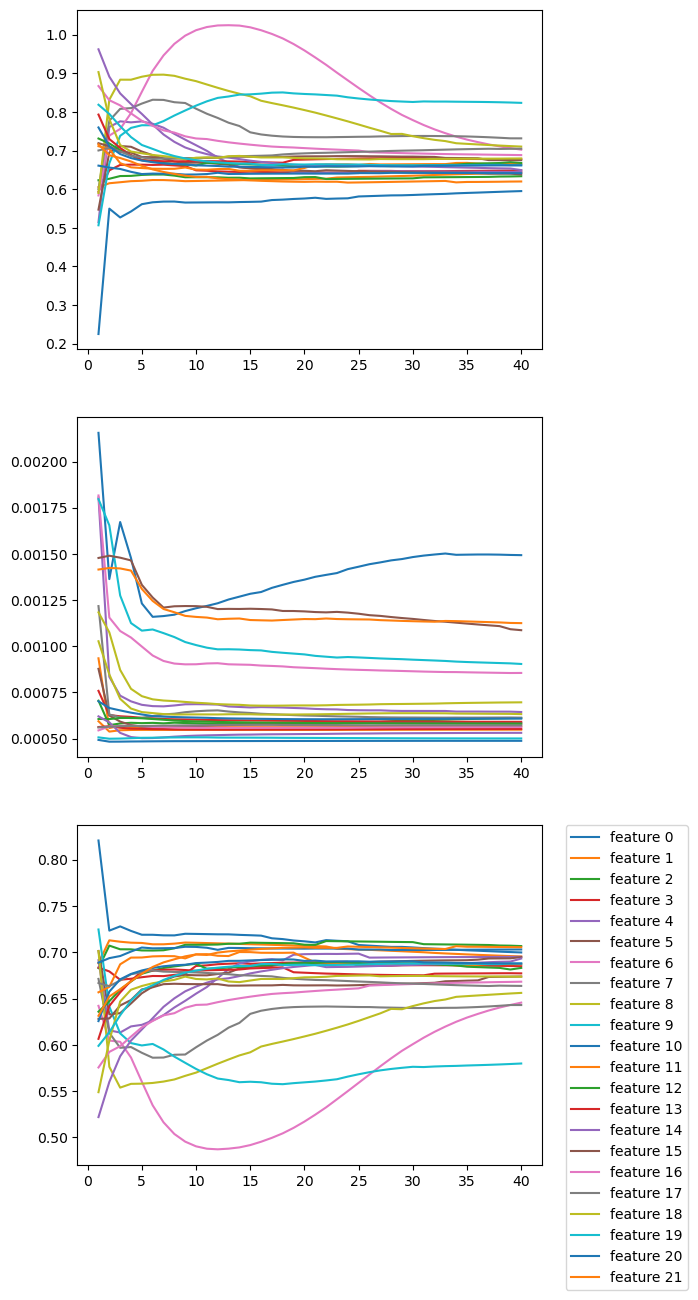

In [205]:
from matplotlib import pyplot as plt
n_cols = 5
client_idx = 0
fig, axes = plt.subplots(3, 1, figsize=(6, 15), squeeze=False)
x = iter_list
for feature_idx in feature_list:
    kl, mean, cos = get_weight_kl(client_idx, feature_idx=feature_idx, records1=records3, records2=records4)
    axes[0, 0].plot(x, kl, label="feature {}".format(feature_idx))
    axes[1, 0].plot(x, mean, label="feature {}".format(feature_idx))
    axes[2, 0].plot(x, cos, label="feature {}".format(feature_idx))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

In [228]:
client_infos3 = stats3[0][0].client_infos
client_infos4 = stats4[0][0].client_infos


retsavg = []
retsmechw = []
for client_id in range(20):
    print("====================================================================================")
    data_savg = client_infos3[client_id].data_imp[-1]
    data_mechw = client_infos4[client_id].data_imp[-1]
    data_true = client_infos3[client_id].data_true
    print(ot.sliced_wasserstein_distance(data_savg, data_mechw))
    print(ot.sliced_wasserstein_distance(data_savg, data_true))
    print(ot.sliced_wasserstein_distance(data_mechw, data_true))
    retsavg.append(ot.sliced_wasserstein_distance(data_savg, data_true))
    retsmechw.append(ot.sliced_wasserstein_distance(data_mechw, data_true))

print("----")
print(np.mean(retsavg))
print(np.mean(retsmechw))

0.025164164080556512
0.03086476845322368
0.023854853411881975
0.027863639254119926
0.04125968649947135
0.025196931722905675
0.02571009864354782
0.037976950191931966
0.02915791842643634
0.025970832563574905
0.03832545874697557
0.02711859451075166
0.023600869206380406
0.0340075837772337
0.029307101792925463
0.027034492343916326
0.033039774083406075
0.034215905154267756
0.031787477872033496
0.03662494234633011
0.021750473200470914
0.030799563770755014
0.03582684293045333
0.026178764567386874
0.02923273214996115
0.03338047356095501
0.02767046214443974
0.03047668897297693
0.03639915542053889
0.02764147616969246
0.06428261725508029
0.116550348266479
0.08395962334177573
0.07520419487879101
0.12096829375287796
0.07581652090381708
0.06718374216318504
0.12115458351386296
0.08205125653907056
0.06464627987558468
0.11291484159212645
0.0699854490039396
0.05816788184137472
0.10041835031057086
0.06274405599503231
0.06676600380650266
0.12402083842385819
0.08129109354320303
0.0798618742057407
0.12575232

# Debug

In [ ]:
exp_config5 = experiment_config_template.copy()
exp_config5['dataset_name'] = 'ijcnn_balanced'
exp_config5['num_clients'] = 20
exp_config5['data_partition']['strategy'] = 'sample@p=0.01'
exp_config5["missing_simulate"]["mr_strategy"] = "random_in_group2"
exp_config5["missing_simulate"]["mm_strategy"] = "mnar_lr"
exp_config5["agg_strategy_imp"]["strategy"] = "fedmechw"
exp_config5["server"]["imp_round"] = 40

experiment = Experiment()
ret5, stats5 = experiment.run_experiment(exp_config5)